In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.integrate import solve_ivp
from numba import njit

In [ ]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 28.0) + 273.15
    
def temperature_const(t,offset = 0): # Constant temperature
    return 301

def humidity(t, offset = 0): # Humidity function in percent
    return 60 #+ 30*np.cos(6*np.pi*(t + offset)/365.25 + 9.2) + 10*np.cos(8*np.pi*(t + offset)/365.25 + 9.2)

In [ ]:
def allee(M, Ms):
    return (0.1 *M + 0.01 *Ms) / (1 + 0.1 *M + 0.01 * Ms)

def event(i, state, M_event):
    return state + M_event[i]

def release1(M, n):
    return n*M + 2000

def competition1(K0, Kh, precip):
    return 1/(K0 + Kh *  precip)

def competition2(K0, Kh, preciptemp):
    return rsp/deltaA * (K0 + Kh * (T/298)*np.exp(0.05*(1 - H/100)))

In [ ]:
#open the meteorological data
import pandas as pd
meteo_df = pd.read_csv('../Data/meteo_tetiaroa_resampled.csv')
print("Columns in meteo_df:", meteo_df.columns)

meteo_df = meteo_df.dropna(subset=['precip', 'precip1', 'precip2', 'precip4', 'UM', 'TM', 'date', 'time'])
precip_data = meteo_df['precip'].values
precip1_data = meteo_df['precip1'].values
precip2_data = meteo_df['precip2'].values
precip4_data = meteo_df['precip4'].values
hum_data = meteo_df['UM'].values
temperature_data = meteo_df['TM'].values
dates_data = meteo_df['date'].values
dates_dt = pd.to_datetime(dates_data)
time_data = meteo_df['time'].values

Columns in meteo_df: Index(['date', 'time', 'TM', 'precip', 'precip1', 'precip2', 'precip4', 'UM'], dtype='object')


In [ ]:
mean_rain = np.mean(precip_data)
max_rain = np.max(precip_data)
print("Mean Rain:", mean_rain)
print("Max Rain:", max_rain)

Mean Rain: 4.577979295358808
Max Rain: 125.3


In [ ]:
Precmax = np.max(precip_data)
deltaprecip = 0.00001 * (25 + temperature_data ** 2) * (100 - hum_data)
# Cumsum of the deltaprecip normalized by Precmax, where value minimum is 0 and maximum is Precmax
H_data = np.zeros_like(precip_data)
H_data[0] = mean_rain*6
for i in range(1, len(precip_data)):
    H_data[i] = min(max_rain, max(0, H_data[i-1] + precip_data[i] - deltaprecip[i]))

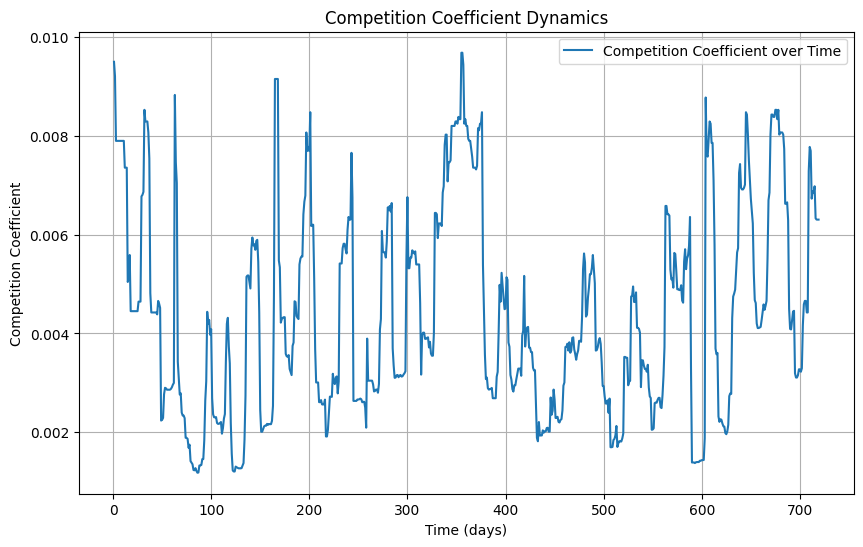

In [ ]:
#plot the competition through time
comp_history = []
c = 0.01
T_max = 720
for t in range(1, T_max):
    precip = np.interp(t, time_data, precip2_data)
    comp = competition2(1/c, 1/(c*30), precip)
    comp_history.append(comp)

plt.figure(figsize=(10, 6))
plt.plot(range(1, T_max), comp_history, label='Competition Coefficient over Time')
plt.xlabel('Time (days)')
plt.ylabel('Competition Coefficient')
plt.title('Competition Coefficient Dynamics')
plt.legend()
plt.grid()
plt.show()

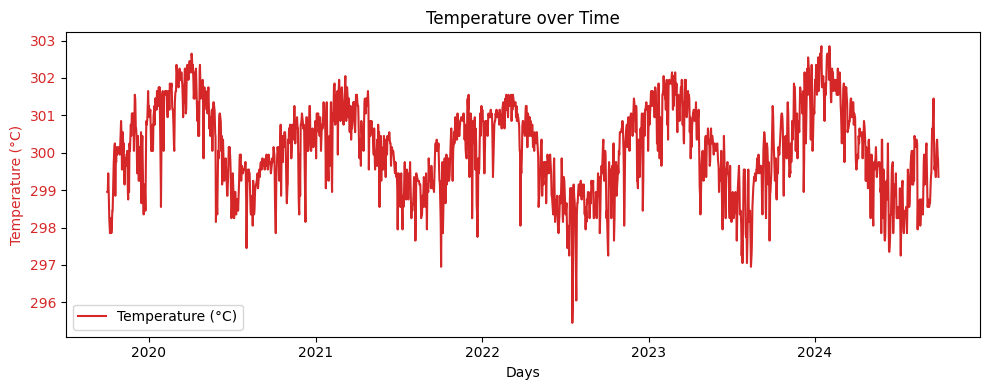

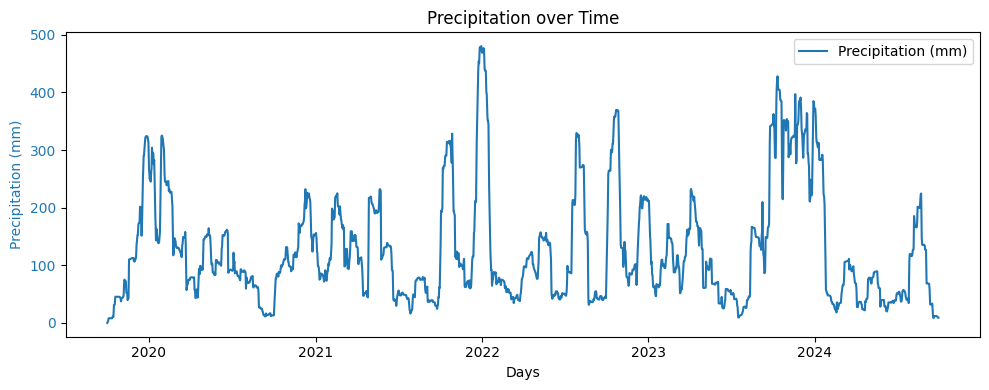

In [ ]:
# Plot temperature and precipitation in two separate graphs
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(dates_dt, temperature_data + 273.15, label='Temperature (°C)', color='tab:red')
ax1.set_xlabel('Days')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_title('Temperature over Time')
plt.legend()
plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(dates_dt, precip4_data, label='Precipitation (mm)', color='tab:blue')
ax2.set_xlabel('Days')
ax2.set_ylabel('Precipitation (mm)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Precipitation over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Population model

In [ ]:
#@njit
def det_model_fast8(t, y, birth, n_egg, deltaA, death_egg, tel, tlp, transi, death_L, death_P, c, mu, t_data, precip_data, H, type = 1):
    E, L, P, F, Ff, Fs, M, Ms = y

    if type == 1:
        precip = np.interp(t, t_data, precip_data)
        comp = competition1(1/c, 1/(c * 50), precip)
    
    if type == 2:
        water = np.interp(t, t_data, H)
        comp = 1 /((1 /(0.2 * c) * water / (max_rain) + 1/(5 * c)))

    if M > 0:
        probaM = M / (M + Ms)
        probaMs = Ms / (M + Ms)

    else:
        probaM = 0.0
        probaMs = 0.0

    matf = allee(M, Ms) * probaM
    mats = allee(M, Ms) * probaMs

    dE_dt = n_egg * birth * Ff - death_egg * E - tel * E
    dL_dt = tel * E - tlp * L - death_L * L - comp * L ** 2
    dP_dt = tlp * L - (transi + death_P) * P
    dF_dt = mu * transi * P - (matf + mats + deltaA) * F
    dFf_dt = matf * F - deltaA * Ff
    dFs_dt = mats * F - deltaA * Fs
    dM_dt = (1 - mu) * transi * P - deltaA * 3 * M
    dMs_dt = - deltaA * 3* 1.2 * Ms

    return np.array([dE_dt, dL_dt, dP_dt, dF_dt, dFf_dt, dFs_dt, dM_dt, dMs_dt])


def sim_fast8(pop_init, days, birth, deltaA, deltaE, transi_el, transi_lp, transi_pa, death_L, death_P, c, mu,n_egg=64, precip_data=precip_data, H = H_data, type = 1):
    
    sol = solve_ivp(
        lambda t, y: det_model_fast8(
            t, y, birth, n_egg, deltaA, deltaE, transi_el, transi_lp, transi_pa, death_L, death_P, c, mu,
            time_data, precip_data, H, type
        ),
        [days[0], days[-1]],
        pop_init,
        t_eval=days,
        method='LSODA',  # or 'RK45'
        vectorized=False
    )

    return sol.y  # [E, F, Ff, Fs, M, Ms]

In [ ]:
init_egg = 10000  # Starting egg population
init_l = 1000 # Starting larval population
init_p = 1000 # Starting pupal population
init_f0 = 100 # Starting female population
init_ff = 1200 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 400 # Starting adult population
init_sterile = 0 # Starting sterile male population
n_rel = 0
n_egg = 64

In [ ]:
# Parameters
birth = 10/64  # Birth rate per adult
mu = 0.51    # rate at which egg becomes a female
egg_death = 0.046    # Death rate per egg
larva_death = 0.05   # Death rate per larva
pupa_death = 0.05   # Death rate per pupa
female_death = 0.046  # Death rate per adult
male_death = 0.139    # Death rate per adult
sterile_death = male_death*1.2   # Death rate per sterile
c = 0.01 # Competition coefficient for larvae
transi_el = 0.79
transi_lp = 0.125
transi_pa = 0.125
t=0.0

days = np.linspace(0, 1552, 155100)  # Time steps
pop = [init_egg, init_l, init_p, init_f0, init_ff, init_fs, init_male, init_sterile]

In [ ]:
E, L, P, F, Ff, Fs, M, Ms = sim_fast8(pop, time_data, birth, female_death,egg_death, transi_el, transi_lp, transi_pa, larva_death, pupa_death, c, mu, n_egg=n_egg, precip_data = precip2_data, H = H_data, type = 1)
print(max(E), max(F), max(Ff), max(Fs), max(M), max(Ms))
print(min(E), min(F), min(Ff), min(Fs), min(M), min(Ms))

39182.57823529508 172.95804909334484 3281.781230561457 0.0 1174.2049239094029 0.0
10000.0 52.28816103046249 1186.5851531211088 0.0 380.1115774866291 0.0


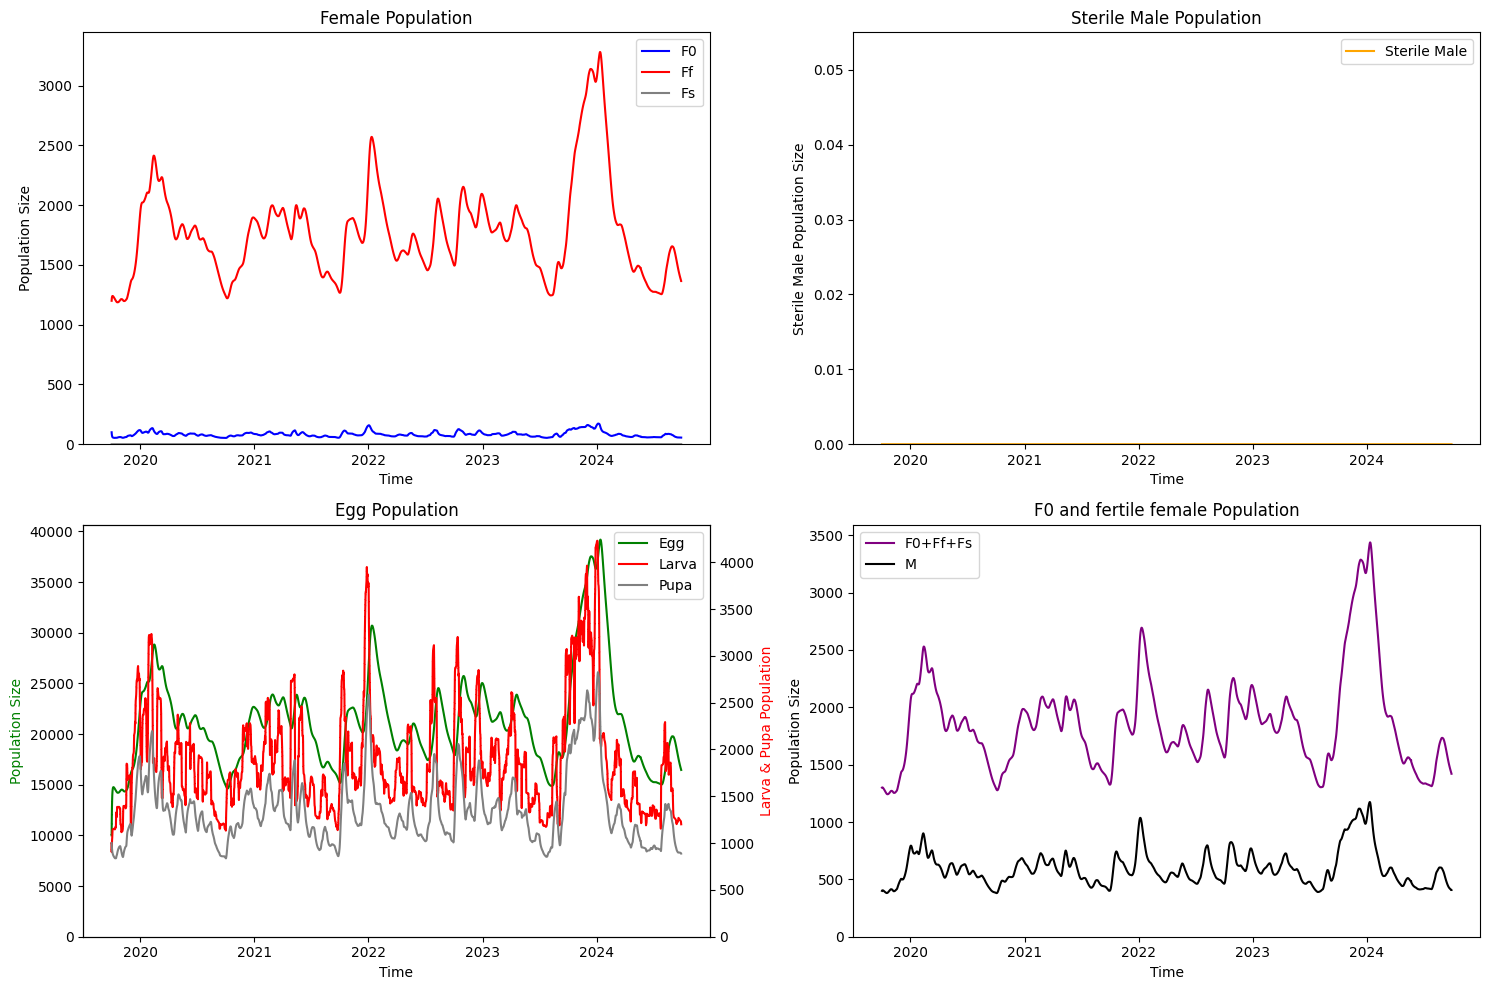

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(dates_dt, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(dates_dt, Ff, where="post", label='Ff', color = 'red')
axs[0, 0].step(dates_dt, Fs, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_ylim(bottom=0)
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(dates_dt, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
ax1_0 = axs[1, 0]
ax1_0_right = ax1_0.twinx()

ax1_0.step(dates_dt, E, where="post", label='Egg', color='green')
ax1_0_right.step(dates_dt, L, where="post", label='Larva', color='red')
ax1_0_right.step(dates_dt, P, where="post", label='Pupa', color='grey')
ax1_0.set_ylim(bottom=0)
ax1_0_right.set_ylim(bottom=0)

ax1_0.set_ylabel('Egg Population', color='green')
ax1_0_right.set_ylabel('Larva & Pupa Population', color='red')

# Combine legends from both axes
lines1, labels1 = ax1_0.get_legend_handles_labels()
lines2, labels2 = ax1_0_right.get_legend_handles_labels()
ax1_0.legend(lines1 + lines2, labels1 + labels2, loc='best')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')

axs[1, 1].step(dates_dt,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(dates_dt, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


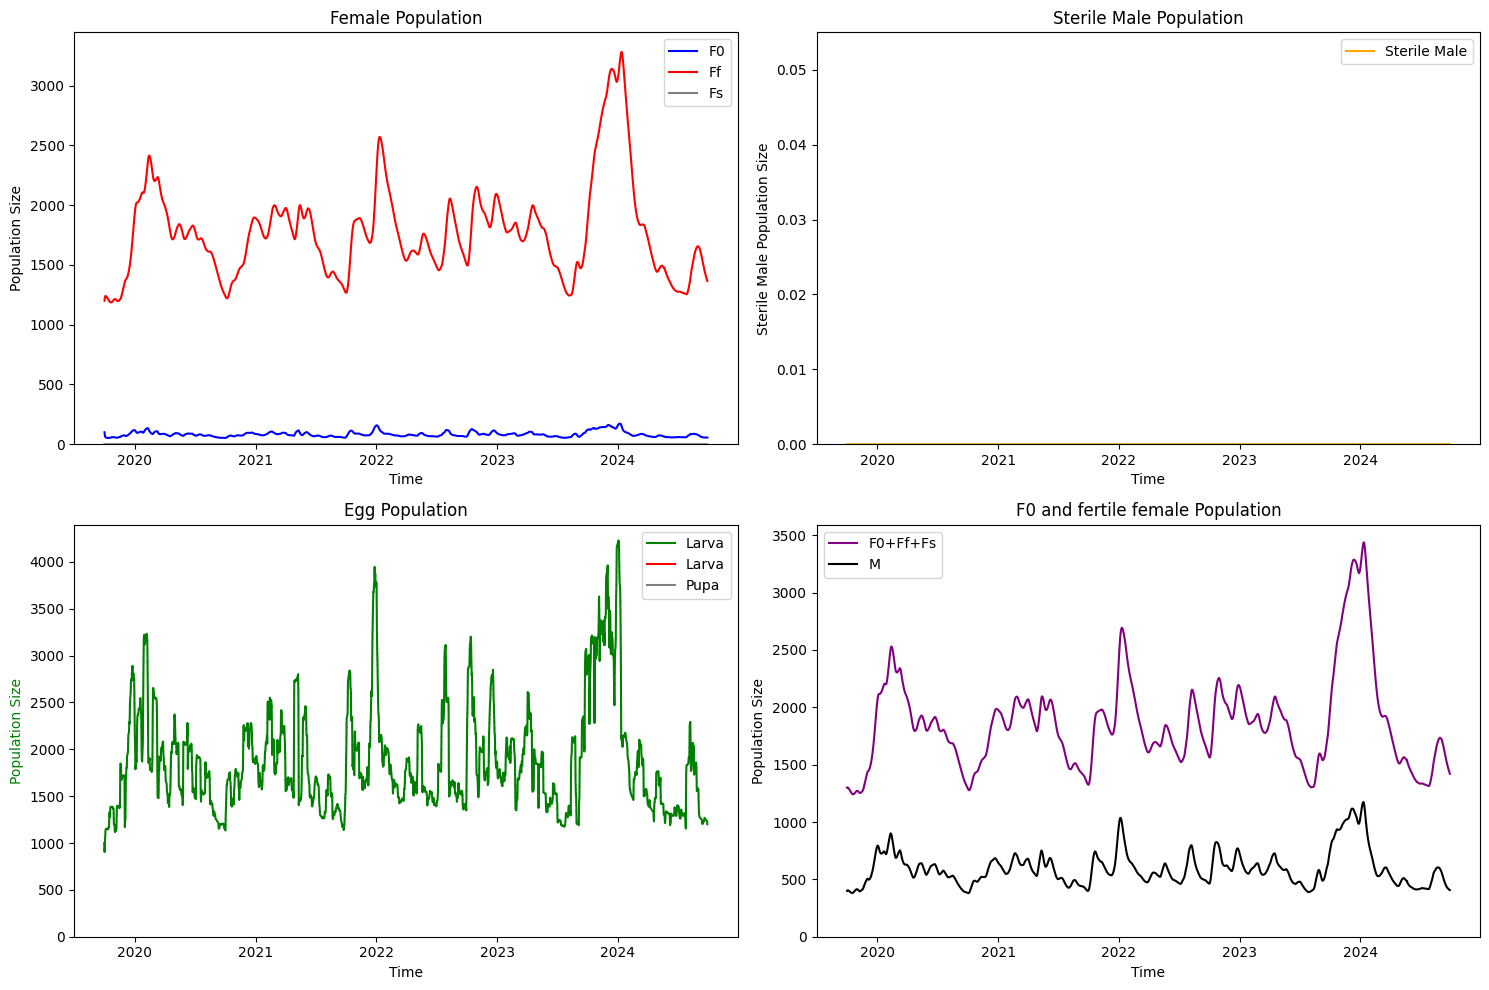

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(dates_dt, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(dates_dt, Ff, where="post", label='Ff', color = 'red')
axs[0, 0].step(dates_dt, Fs, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_ylim(bottom=0)
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(dates_dt, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
ax1_0 = axs[1, 0]

ax1_0.step(dates_dt, L, where="post", label='Larva', color='green')
ax1_0.set_ylim(bottom=0)

ax1_0.set_ylabel('Larva Population', color='green')

# Combine legends from both axes
lines1, labels1 = ax1_0.get_legend_handles_labels()
lines2, labels2 = ax1_0_right.get_legend_handles_labels()
ax1_0.legend(lines1 + lines2, labels1 + labels2, loc='best')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')

axs[1, 1].step(dates_dt,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(dates_dt, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
def sim_fast8_with_intervention(pop_init, days, t_interv, birth, deltaA, deltaE,
                                transi_el, transi_lp, transi_pa, death_L, death_P,
                                c, mu, n_egg=64, precip_data=precip_data,
                                H=H_data, type=1):

    y_t = []
    t_t = []

    current_state = np.array(pop_init, dtype=float)
    t_prev = days[0]

    # times at which we evaluate solution
    remaining_eval_times = list(days)

    for t_next in list(t_interv) + [days[-1] + 1]:

        # evaluation times *before the next intervention*
        eval_segment = [t for t in remaining_eval_times if t_prev <= t < t_next]

        if len(eval_segment) > 0:
            sol = solve_ivp(
                lambda t, y: det_model_fast8(
                    t, y, birth, n_egg, deltaA, deltaE,
                    transi_el, transi_lp, transi_pa, death_L, death_P,
                    c, mu, time_data, precip_data, H, type),
                [t_prev, eval_segment[-1]],
                current_state,
                t_eval=eval_segment,
                method='LSODA'
            )

            y_t.append(sol.y)
            t_t.append(sol.t)
            current_state = sol.y[:, -1]

        # remove used eval times
        remaining_eval_times = [t for t in remaining_eval_times if t >= t_next]

        # --- IMPULSE: ADD STERILE MALES ---
        if t_next in t_interv:
            M = current_state[6]
            addition = max(10000, 100 * M + 2000)
            current_state[7] += addition   # Ms += addition
            # print(f"Added {addition:.0f} sterile males at t={t_next}")

        t_prev = t_next

    # concatenate
    T = np.concatenate(t_t)
    Y = np.concatenate(y_t, axis=1)

    # reorder to match global days array
    idx = np.argsort(T)
    return Y[:, idx]


In [ ]:
t_interv = np.array([252.00, 259.00, 266.00, 273.00, 280.00, 287.00, 294.00, 301.00, 308.00, 315.00, 322.00, 329.00, 336.00, 343.00, 350.00, 357.00, 364.00, 371.00, 378.00, 385.00, 392.00, 399.00, 406.00, 413.00, 420.00])
print(len(t_interv))
t_max_interv = 576.97
time_data_interv = np.linspace(0, t_max_interv, int(t_max_interv*100)+1)

25


In [ ]:
Ei, Li, Pi, Fi, Ffi, Fsi, Mi, Msi = sim_fast8_with_intervention(pop, time_data_interv, t_interv, birth, female_death,egg_death, transi_el, transi_lp, transi_pa, larva_death, pupa_death, c, mu, n_egg=n_egg, precip_data = precip2_data, H = H_data, type = 1)
print(max(Ei), max(Fi), max(Ffi), max(Fsi), max(Mi), max(Msi))
print(min(Ei), min(Fi), min(Ffi), min(Fsi), min(Mi), min(Msi))

28833.751732808323 134.66467716079555 2414.623020711655 1053.318393076101 901.1672569207317 84822.47349342333
6.913346170702817 1.3407540451407116 0.5757534656341888 -6.682885717252188e-13 7.963990920244671 0.0


ValueError: x and y must have same first dimension, but have shapes (57698,) and (187301,)

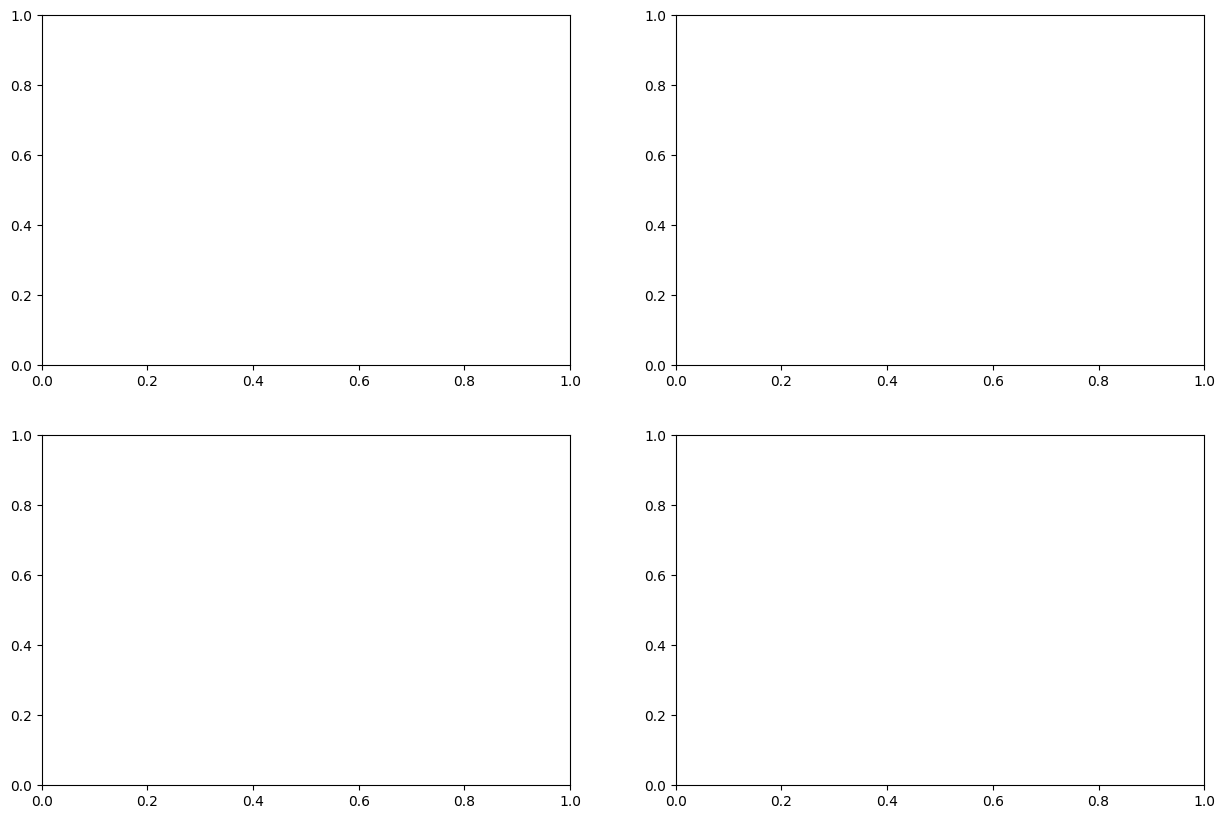

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(time_data_interv, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(time_data_interv, Ff, where="post", label='Ff', color = 'red')
axs[0, 0].step(time_data_interv, Fs, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_ylim(bottom=0)
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(time_data_interv, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
ax1_0 = axs[1, 0]

ax1_0.step(time_data_interv, L, where="post", label='Larva', color='green')
ax1_0.set_ylim(bottom=0)

ax1_0.set_ylabel('Larva Population', color='green')

# Combine legends from both axes
ax1_0.legend(lines1 + lines2, labels1 + labels2, loc='best')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')

axs[1, 1].step(time_data_interv,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(time_data_interv, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Go simpler version

In [ ]:
transiL_mod = transi_lp ** 2 / (pupa_death + transi_pa)
pop3 = [init_f0 + init_ff, init_male, init_sterile]
t = 0.0
c = 85

In [ ]:
#@njit
def det_model_fast3(t, y, birth, n_egg, deltaA, death_egg, tel, transi_mod, death_L, c, t_data, precip_data, H, type = 1):
    F, M, Ms = y

    if type == 1:
        precip = np.interp(t, t_data, precip_data)
        comp = competition1(1/c, 1/(c * 50), precip)
    
    if type == 2:
        water = np.interp(t, t_data, H)
        comp = 1 /((1 /(0.2 * c) * water / (max_rain) + 1/(5 * c)))

    if M > 0:
        probaM = M / (M + Ms)

    else:
        probaM = 0.0

    matf = allee(M, Ms) * probaM
    birth_mod = birth * matf * tel / (tel + death_egg)

    birth_rate = ( -(death_L + transi_mod) + np.sqrt((death_L + transi_mod)**2 + F * 4 * comp * birth_mod) )/ (2 * comp)

    dF_dt = birth_rate * n_egg / 2 - deltaA * F
    dM_dt = birth_rate * n_egg / 2 - deltaA * 3 * M
    dMs_dt = - deltaA * 3* 1.2 * Ms

    return np.array([dF_dt, dM_dt, dMs_dt])

def sim_fast3(pop_init, days, birth, deltaA, deltaE, transi_el, transi_mod, death_L, c,n_egg=64, precip_data=precip_data, H = H_data, type = 1):
    
    sol = solve_ivp(
        lambda t, y: det_model_fast3(
            t, y, birth, n_egg, deltaA, deltaE, transi_el, transi_mod, death_L, c,
            time_data, precip_data, H, type
        ),
        [days[0], days[-1]],
        pop_init,
        t_eval=days,
        method='LSODA',  # or 'RK45'
        vectorized=False
    )

    return sol.y  # [F, M, Ms]

In [ ]:
F3, M3, Ms3 = sim_fast3(pop3, time_data, birth, female_death, egg_death, transi_el, transiL_mod, larva_death, c, n_egg=n_egg, precip_data = precip2_data, H = H_data, type = 1)
print(max(F3), max(M3), max(Ms3))
print(min(F3), min(M3), min(Ms3))

3489.4682297041627 1268.2644856591303 0.0
1147.2136188971274 354.574709896585 0.0


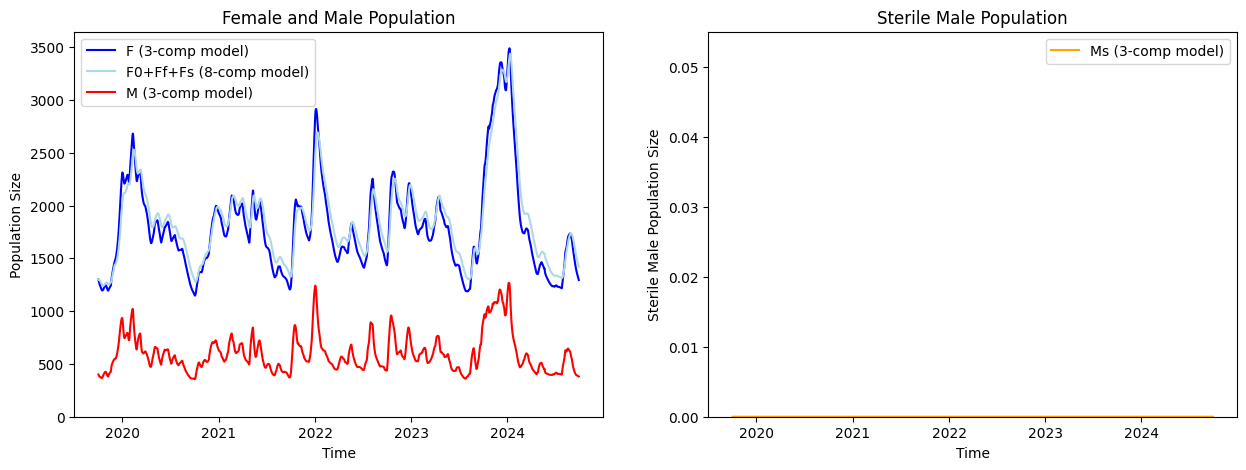

In [ ]:
#Plot with female and male (f et m), and plot for sterile male
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plot results
axs[0].step(dates_dt, F3, where="post", label='F (3-comp model)', color='blue')
axs[0].step(dates_dt, [F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs (8-comp model)', color='lightblue')
axs[0].step(dates_dt, M3, where="post", label='M (3-comp model)', color='red')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Population Size')
axs[0].set_ylim(bottom=0)
axs[0].set_title('Female and Male Population')
axs[0].legend()

axs[1].step(dates_dt, Ms3, where="post", label='Ms (3-comp model)', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sterile Male Population Size')
axs[1].set_ylim(bottom=0)
axs[1].set_title('Sterile Male Population')
axs[1].legend()